This example opens a CZ CryoET Data Portal project dataset and creates an overlay in /tmp.

We then visualize the multiscale segmentation from `segmentation_from_picks` to confirm that it is valid.

In [ ]:
import copick

proj = copick.from_czcdp_datasets([10441], overlay_root="/tmp/test/", output_path='test.config', user_id='icequeen', session_id='0', overlay_fs_args={"auto_mkdir": True})

print(proj.pickable_objects)

{'auto_mkdir': True}
[CopickObject(name=membrane, is_particle=False, label=1, color=(0, 255, 0, 255), emdb_id=None, pdb_id=None, identifier=GO:0016020 threshold=None) at 0x13faa4580, CopickObject(name=ferritin-complex, is_particle=True, label=2, color=(255, 0, 255, 255), emdb_id=EMD-41923, pdb_id=None, identifier=GO:0070288 threshold=None) at 0x13faa4460, CopickObject(name=thyroglobulin, is_particle=True, label=3, color=(0, 127, 255, 255), emdb_id=EMD-24181, pdb_id=None, identifier=UniProtKB:P01267 threshold=None) at 0x141722ce0, CopickObject(name=virus-like-capsid, is_particle=True, label=4, color=(255, 127, 0, 255), emdb_id=EMD-41917, pdb_id=None, identifier=GO:0170047 threshold=None) at 0x1417231c0, CopickObject(name=beta-amylase, is_particle=True, label=5, color=(127, 191, 127, 255), emdb_id=EMD-30405, pdb_id=None, identifier=UniProtKB:P10537 threshold=None) at 0x141722e30, CopickObject(name=beta-galactosidase, is_particle=True, label=6, color=(94, 6, 164, 255), emdb_id=EMD-0153, p

In [2]:
pickable_object = proj.pickable_objects[0]
radius = pickable_object.radius
painting_segmentation_name = "ribosomeTest"
run = proj.runs[0]
voxel_spacing = 10
tomo_type = "wbp"
pick_set = run.get_picks(object_name="cytosolic-ribosome")[0]
pick_set

CopickPicks(pickable_object_name=cytosolic-ribosome, user_id=data-portal, session_id=74238, len(points)=148) at 0x13f5f99c0

In [3]:
from copick_utils.segmentation.segmentation_from_picks import segmentation_from_picks


seg = segmentation_from_picks(radius, painting_segmentation_name, run, voxel_spacing, tomo_type, pickable_object, pick_set, user_id="paintedPicks", session_id="0")



segmentation keys /
 ├── 0 (200, 630, 630) uint16
 ├── 1 (100, 315, 315) uint16
 └── 2 (50, 158, 158) uint16


In [4]:
import zarr

import numpy as np

z = zarr.open(seg.zarr().path, "r")

print([(z[k], np.min(z[k][:]), np.max(z[k][:])) for k in ["0", "1", "2"]])

[(<zarr.core.Array '/0' (200, 630, 630) uint16 read-only>, 0, 1), (<zarr.core.Array '/1' (100, 315, 315) uint16 read-only>, 0, 1), (<zarr.core.Array '/2' (50, 158, 158) uint16 read-only>, 0, 1)]


In [5]:
np.max(z["0"][:])

1

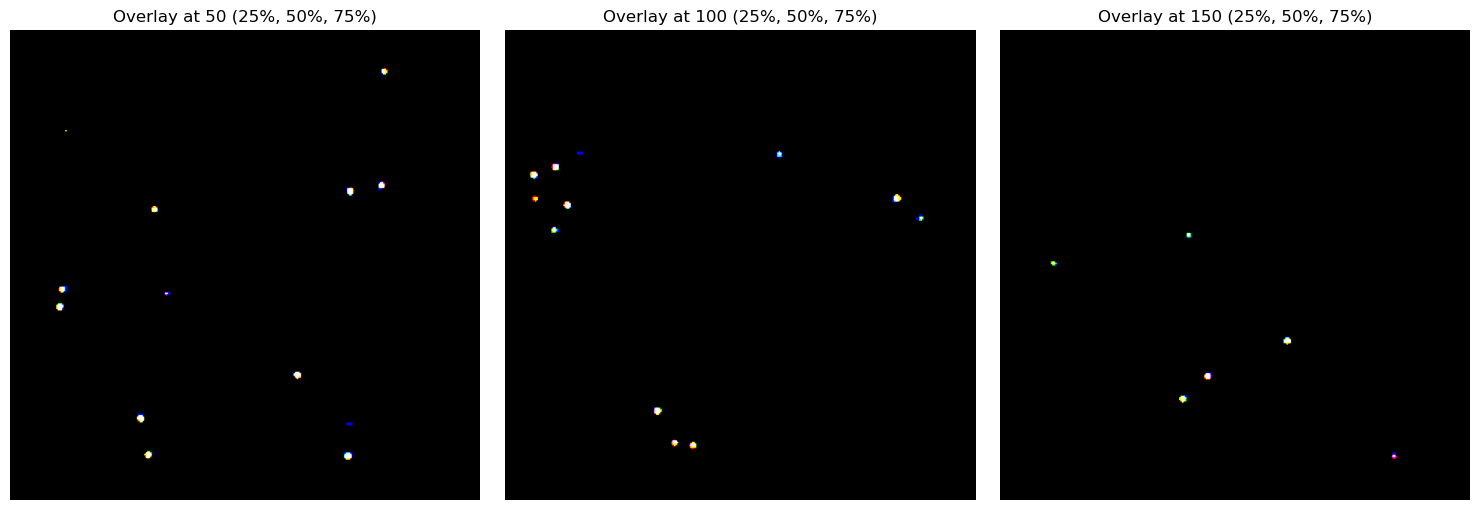

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import resize

# Load the Zarr arrays
zarr_arrays = [z["0"][:], z["1"][:], z["2"][:]]

# Define the dimensions of the highest resolution scale
target_shape = zarr_arrays[0].shape

# Fetch scale factors for each level
scales = [1, 2, 4]# TODO manual hard coding, fix this

# Calculate slice indices for the highest resolution
slice_indices = [int(target_shape[0] * frac) for frac in [0.25, 0.5, 0.75]]
scaled_slice_indices = [[int(slice_idx / scale) for slice_idx in slice_indices] for scale in scales]

# Adjust contrast by scaling each slice to its min and max values
def adjust_contrast(slice_data):
    """Normalize the contrast of a 2D slice."""
    min_val, max_val = slice_data.min(), slice_data.max()
    if max_val > min_val:  # Avoid division by zero
        return (slice_data - min_val) / (max_val - min_val)
    else:
        return slice_data

# Rescale lower resolution arrays to match the highest resolution
rescaled_arrays = [
    resize(arr, target_shape, order=0, preserve_range=True).astype(np.float32)
    for arr in zarr_arrays
]

# Plot the combined overlays for 25%, 50%, and 75% slices
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
colors = ["red", "green", "blue"]  # Colors for each scale

for i, slice_idx in enumerate(slice_indices):
    # Initialize an RGB image with zeros
    rgb_image = np.zeros((*target_shape[1:], 3), dtype=np.float32)
    
    # Combine slices from different scales into RGB channels
    for j, (arr, color) in enumerate(zip(rescaled_arrays, colors)):
        slice_data = arr[slice_idx]  # Use the same slice index since it's rescaled
        adjusted_slice = adjust_contrast(slice_data)
        
        if color == "red":
            rgb_image[..., 0] += adjusted_slice
        elif color == "green":
            rgb_image[..., 1] += adjusted_slice
        elif color == "blue":
            rgb_image[..., 2] += adjusted_slice
    
    # Normalize the RGB channels to keep the values in the range [0, 1]
    rgb_image = np.clip(rgb_image, 0, 1)
    
    # Plot the resulting RGB overlay
    axes[i].imshow(rgb_image)
    axes[i].set_title(f"Overlay at {slice_idx} (25%, 50%, 75%)")
    axes[i].axis("off")

plt.tight_layout()
plt.show()

